In [ ]:
#!pip install --upgrade tensorflow==2.4
#!pip install --upgrade tensorflow-probability==0.12

In [1]:
try:
  import mat73
except:
  !pip install -q mat73
  import mat73

In [2]:
!pip install -q tensorflow==2.15.0
!pip install -q tensorflow-probability==0.23

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.63 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.5 MB/s eta 0:00:00


In [3]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
import time
import pandas as pd
import scipy
import scipy.io
import seaborn as sns
from numpy import linalg as LA
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import randomized_svd
from matplotlib.animation import FuncAnimation, writers

from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

#from keras.callbacks import Callback

In [5]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv2D, ConvLSTM2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, ReLU, Input
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, UpSampling2D, TimeDistributed, LayerNormalization
from tensorflow.keras.layers import Dropout, BatchNormalization

In [6]:
!pip freeze | grep tensorflow

tensorflow==2.15.0
tensorflow-datasets==4.9.6
tensorflow-estimator==2.15.0
tensorflow-hub==0.16.1
tensorflow-io-gcs-filesystem==0.37.1
tensorflow-metadata==1.15.0
tensorflow-probability==0.23.0


In [7]:
font = {'size'   : 18}

matplotlib.rc('font', **font)

In [8]:
print(tf.__version__)
print(tfp.__version__)

tf.test.gpu_device_name()

2.15.0
0.23.0


'/device:GPU:0'

In [9]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3000483565877915327
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10758393372099992382
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [10]:
seed = 98374598
tf.random.set_seed(seed)
np.random.seed(seed)

# 1. Load Data

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# set working directory
import os
os.chdir("//content/drive/My Drive/abadiaheredia_etal_2024/")

In [33]:
data_dict = mat73.loadmat('DATA/dataset_laminar.mat')
Ten_orig = data_dict['Tensor'][:,:,:,:,100:]

In [34]:
print(Ten_orig.shape)

(3, 100, 40, 64, 499)


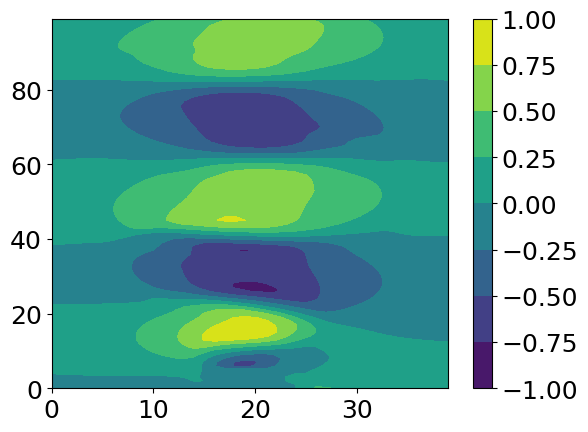

In [37]:
plt.contourf(Ten_orig[1,:,:,32,300])
plt.colorbar()

# 2. Data Split

In [15]:
# Streamwise velocity
"""
train_set = np.copy(Ten_orig[0:1,...,:int(0.6*Ten_orig.shape[-1])])
dev_set = np.copy(Ten_orig[0:1,...,int(0.6*Ten_orig.shape[-1]):int(0.65*Ten_orig.shape[-1])])
test_set = np.copy(Ten_orig[0:1,...,int(0.65*Ten_orig.shape[-1]):])
"""

# Wall-normal velocity
train_set = np.copy(Ten_orig[1:2,...,:int(0.6*Ten_orig.shape[-1])])
dev_set = np.copy(Ten_orig[1:2,...,int(0.6*Ten_orig.shape[-1]):int(0.65*Ten_orig.shape[-1])])
test_set = np.copy(Ten_orig[1:2,...,int(0.65*Ten_orig.shape[-1]):])

# Scailing between 0 and 1
ten_min = np.amin(train_set)
ten_range = np.ptp(train_set)

# ten_min = np.mean(train_set, axis = -1)[..., None]
# ten_range = np.std(train_set)

train_set = (train_set - ten_min) / ten_range
dev_set = (dev_set - ten_min) / ten_range
test_set = (test_set - ten_min) / ten_range

# Channels last, time first
train_set = np.transpose(train_set, [4,1,2,3,0])
dev_set = np.transpose(dev_set, [4,1,2,3,0])
test_set = np.transpose(test_set, [4,1,2,3,0])

print(f"Train set shape: {train_set.shape}")
print(f"Dev set shape: {dev_set.shape}")
print(f"Test set shape: {test_set.shape}")

Train set shape: (299, 100, 40, 64, 1)
Dev set shape: (25, 100, 40, 64, 1)
Test set shape: (175, 100, 40, 64, 1)


In [16]:
print("Training statistics")
print(np.mean(train_set))
print(np.std(train_set))
print(np.min(train_set))
print(np.max(train_set))
print("\n")
print("Validation statistics")
print(np.mean(dev_set))
print(np.std(dev_set))
print(np.min(dev_set))
print(np.max(dev_set))
print("\n")
print("Testing statistics")
print(np.mean(test_set))
print(np.std(test_set))
print(np.min(test_set))
print(np.max(test_set))

Training statistics
0.4999523612184475
0.17113317285424773
0.0
1.0


Validation statistics
0.5005080288042969
0.16105404314393235
0.010337522690367607
0.9923150986907859


Testing statistics
0.49996078734322474
0.16110907202011132
0.007533671164650957
0.9925056502029849


# 3. Data Windowing

In [17]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, samplingRate, batch_size,
            train_df=train_set, val_df=dev_set, test_df=test_set):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.sampling_rate = samplingRate

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}'])

def split_window(self, features):
    inputs = features[:, self.input_slice, ...]
    labels = features[:, self.labels_slice, ...]

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None, None, None])
    labels.set_shape([None, self.label_width, None, None, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data, state):
    data = np.array(data, dtype=np.float32)
    if (state == "training"):
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            sampling_rate = self.sampling_rate,
            shuffle = True,
            batch_size = self.batch_size)

    else:
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            sampling_rate = self.sampling_rate,
            shuffle = False,
            batch_size = self.batch_size)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self, state = "training"):
    return self.make_dataset(self.train_df, state)

@property
def val(self, state = "not_training"):
    return self.make_dataset(self.val_df, state)

@property
def test(self, state = "not_training"):
    return self.make_dataset(self.test_df, state)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [18]:
def window_generator(inputWidth):

  labelWidth=1
  shift=1

  batchSize=8

  w1 = WindowGenerator(input_width = inputWidth, label_width = labelWidth,
                      shift = shift, samplingRate = 1, batch_size = batchSize,
                      train_df = train_set[:,:,:,0,:], val_df = dev_set[:,:,:,0,:],
                       test_df = test_set[:,:,:,0,:])

  w_train = w1.train
  w_val = w1.val

  for i in range(1,Ten_orig.shape[-2]):
    w2 = WindowGenerator(input_width = inputWidth, label_width = labelWidth,
                      shift = shift, samplingRate = 1, batch_size = batchSize,
                      train_df = train_set[:,:,:,i,:], val_df = dev_set[:,:,:,i,:],
                      test_df = test_set[:,:,:,i,:])

    w_train = w_train.concatenate(w2.train)
    w_val = w_val.concatenate(w2.val)

  del w1, w2

  return w_train, w_val

In [19]:
inputWidth = 10

w_train, w_val = window_generator(inputWidth)

Number of training batches: 2368

Inputs shape (batch size, time, features): (8, 10, 100, 40, 1)
Labels shape (batch size, time, features): (8, 1, 100, 40, 1)


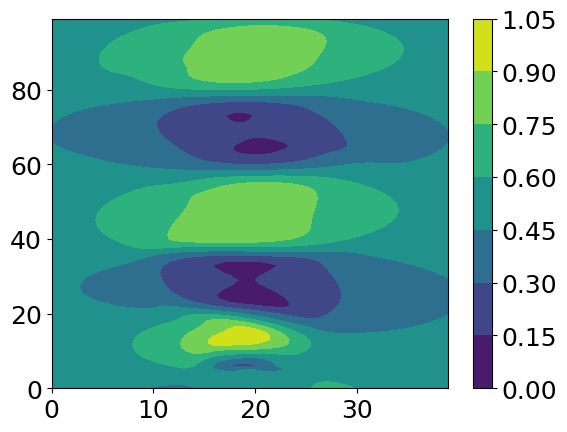

In [20]:
print(f"Number of training batches: {len(w_train)}")

for example_inputs, example_labels in w_train.take(1):
  in_shape = (example_inputs.shape[1], example_inputs.shape[2], example_inputs.shape[3], example_inputs.shape[4])
  print(f'\nInputs shape (batch size, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch size, time, features): {example_labels.shape}')

plt.close('all')
plt.contourf(example_inputs[0,0,:,:,0])
plt.colorbar()

# KL divergence

In [21]:
def get_kl_regularizer(latent_dim):
  """
  The prior of latent variables is considered a standard Normal distribution.
  Therefore this function creates the KLDivergenceRegularizer that will be used
  in the ELBO.
  """

  return tfpl.KLDivergenceRegularizer(
      tfd.MultivariateNormalDiag(loc = tf.zeros(latent_dim),
                                 scale_diag = tf.ones(latent_dim)),
      use_exact_kl = False,
      test_points_fn = lambda q: q.sample(30),
      weight = 1.0,
      test_points_reduce_axis = None)

## Inference

In [22]:
tf.keras.backend.clear_session()

In [23]:
def get_encoder(latent_dim, in_shape, kl_regularizer):

  model = Sequential([
      Input(shape = in_shape),

      Conv2D(filters=8, kernel_size=7, strides=1, padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      Conv2D(filters=16, kernel_size=3, strides=2, padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      Conv2D(filters=32, kernel_size=3, strides=(2,1), padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      ConvLSTM2D(64, (3, 3), strides = (2,1), padding="same",
                 return_sequences=False, data_format='channels_last'),
      LayerNormalization(),

      Flatten(),
      Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),

      tfpl.MultivariateNormalTriL(latent_dim,
        convert_to_tensor_fn = tfp.distributions.Distribution.sample,
        activity_regularizer = kl_regularizer)

  ], name='encoder')

  return model

## Generation

In [24]:
def get_decoder(latent_dim, num_kernels):

  inputs = Input(shape=(latent_dim,))

  x = Dense(units=9856, activation='relu',
            kernel_initializer='he_uniform')(inputs)
  x = Reshape((11,14,64))(x)

  x = Conv2DTranspose(filters=64, kernel_size=3, strides=(2,1), padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)

  x_probs = Flatten()(x)
  x_probs = Dense(num_kernels, activation='softmax')(x_probs)

  x = Conv2DTranspose(filters=32, kernel_size=3, strides=(2,1), padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)

  x = Conv2DTranspose(filters=16, kernel_size=(4,3), strides=2, padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)

  x = Conv2DTranspose(filters=8, kernel_size=(5,4), strides=1, padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)



  x = Conv2D(filters=2*num_kernels, kernel_size=1, strides=1, activation=None,
             padding='valid', data_format='channels_last')(x)
  x = tf.transpose(x, perm = [0,3,1,2])

  x = [x_probs, x]

  outputs = tfpl.DistributionLambda(
    lambda t: tfd.MixtureSameFamily(
        mixture_distribution = tfd.Categorical(probs=t[0]),
        components_distribution = tfd.Independent(
            tfd.MultivariateNormalDiag(loc=t[1][:,:num_kernels,...],
                                       scale_diag=tf.nn.softplus(t[1][:,num_kernels:,...])
                                       ),
                                       reinterpreted_batch_ndims=1
            )
        )
    )(x)

  return Model(inputs=inputs, outputs=outputs, name='decoder')

## Variational Autoencoder

In [25]:
tf.keras.backend.clear_session()

latent_dim = 25

num_kernels_dec = 15

kl_regularizer = get_kl_regularizer(latent_dim)

encoder = get_encoder(latent_dim, in_shape, kl_regularizer)

decoder = get_decoder(latent_dim, num_kernels_dec)

vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [26]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 94, 34, 8)     400       
                                                                 
 re_lu (ReLU)                (None, 10, 94, 34, 8)     0         
                                                                 
 layer_normalization (Layer  (None, 10, 94, 34, 8)     16        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 46, 16, 16)    1168      
                                                                 
 re_lu_1 (ReLU)              (None, 10, 46, 16, 16)    0         
                                                                 
 layer_normalization_1 (Lay  (None, 10, 46, 16, 16)    32        
 erNormalization)                                          

In [27]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 9856)                 256256    ['input_2[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 11, 14, 64)           0         ['dense_1[0][0]']             
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 23, 16, 64)           36928     ['reshape[0][0]']             
 anspose)                                                                                   

In [28]:
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 100, 40, 1)   0         
                             ]                                   
                                                                 
 conv2d (Conv2D)             (None, 10, 94, 34, 8)     400       
                                                                 
 re_lu (ReLU)                (None, 10, 94, 34, 8)     0         
                                                                 
 layer_normalization (Layer  (None, 10, 94, 34, 8)     16        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 46, 16, 16)    1168      
                                                                 
 re_lu_1 (ReLU)              (None, 10, 46, 16, 16)    0     

# Loss Function

In [ ]:
def reconstruction_loss(target_modes, var_posterior):
    """
    This function defines the loss function. Note that only the log likelihood
    is implemented, because the KL term is already included in the encoder.
    """

    return(-tf.reduce_mean(var_posterior.log_prob(tf.squeeze(target_modes))))

# Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
vae.compile(optimizer = optimizer, loss = reconstruction_loss)

In [ ]:
t0 = time.time()

history = vae.fit(w_train, validation_data = w_val, epochs = 30) # 20

t1 = time.time()

print(f"Training time {(t1 - t0)/60} minutes.")

Epoch 1/30
2368/2368 [==============================] - 195s 75ms/step - loss: -3498.1406 - val_loss: -7524.7847
Epoch 2/30
2368/2368 [==============================] - 174s 74ms/step - loss: -9623.5420 - val_loss: -6081.7524
Epoch 3/30
2368/2368 [==============================] - 174s 74ms/step - loss: -10691.1250 - val_loss: -6000.0381
Epoch 4/30
2368/2368 [==============================] - 175s 74ms/step - loss: -11423.6279 - val_loss: -7159.8154
Epoch 5/30
2368/2368 [==============================] - 174s 73ms/step - loss: -12402.4219 - val_loss: -8143.9199
Epoch 6/30
2368/2368 [==============================] - 174s 73ms/step - loss: -13014.7549 - val_loss: -8309.7568
Epoch 7/30
2368/2368 [==============================] - 173s 73ms/step - loss: -13512.8682 - val_loss: -8578.6426
Epoch 8/30
2368/2368 [==============================] - 173s 73ms/step - loss: -13861.6328 - val_loss: -8377.7207
Epoch 9/30
2368/2368 [==============================] - 173s 73ms/step - loss: -14170.9814

In [29]:
"""
vae.save_weights("./Models_weights/weights_vae_laminar_streamwise_new.h5")
vae.save_weights("./Models_weights/weights_vae_laminar_normal_new.h5")
"""

# vae.load_weights("./Models_weights/weights_vae_laminar_streamwise.h5")
vae.load_weights("./Models_weights/weights_vae_laminar_normal.h5")

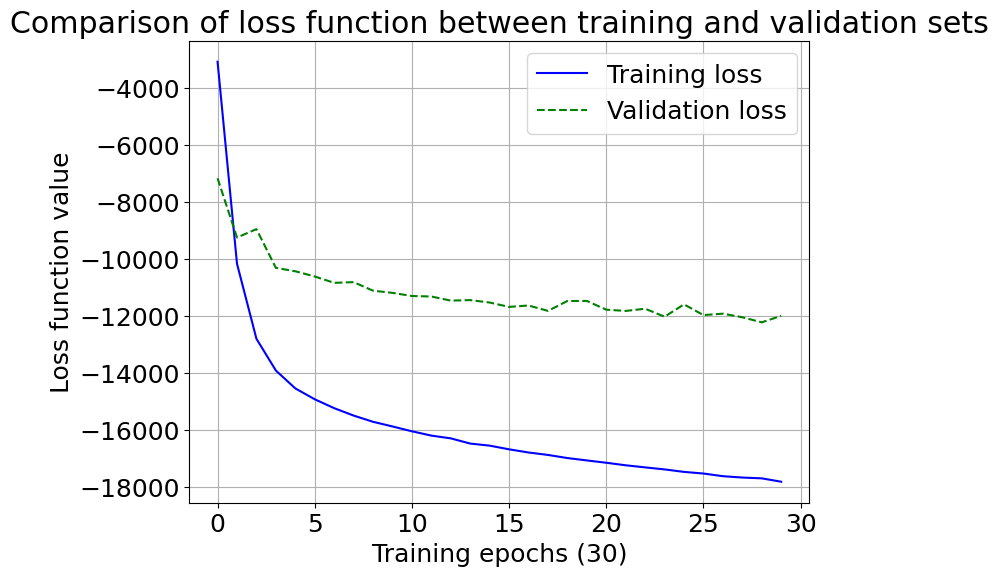

In [ ]:
fig = plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'], 'b', label = 'Training loss') # blue
plt.plot(history.history['val_loss'], 'g--', label = 'Validation loss') # green
plt.xlabel(f'Training epochs ({len(history.history["loss"])})')
plt.ylabel('Loss function value')
plt.title('Comparison of loss function between training and validation sets')
plt.grid()
plt.legend()

# Testing

In [30]:
def evaluate_model_test_iter(ten_orig_1, time_pred = 10, start_pnt = 10):

  ten_orig = np.copy(ten_orig_1)

  predictions = np.empty((ten_orig.shape[1], ten_orig.shape[2],
                          ten_orig.shape[3], time_pred))

  snap = np.copy(ten_orig[..., start_pnt-10:start_pnt])
  snap = (snap - ten_min) / ten_range
  snap = np.transpose(snap, [3,4,1,2,0])

  for i in range(time_pred):

    pred = vae.predict(snap, verbose = 0)

    pred_1 = np.transpose(np.copy(pred), [1,2,0])
    pred_1 = pred_1 * ten_range + ten_min

    predictions[...,i] = pred_1

    pred = pred[:,None,:,:,None]
    snap = np.concatenate([snap[:,1:,:,:,:], pred], axis = 1)

  del ten_orig, snap, pred, pred_1

  return predictions

In [31]:
t0 = time.time()

start_pnt = train_set.shape[0]
predictions = evaluate_model_test_iter(Ten_orig[1:2,...], 200, start_pnt)

t1 = time.time()
print("Seconds elapsed: %f" % (t1 - t0))

Seconds elapsed: 49.900007


Text(0.5, 1.0, 'Forecast')

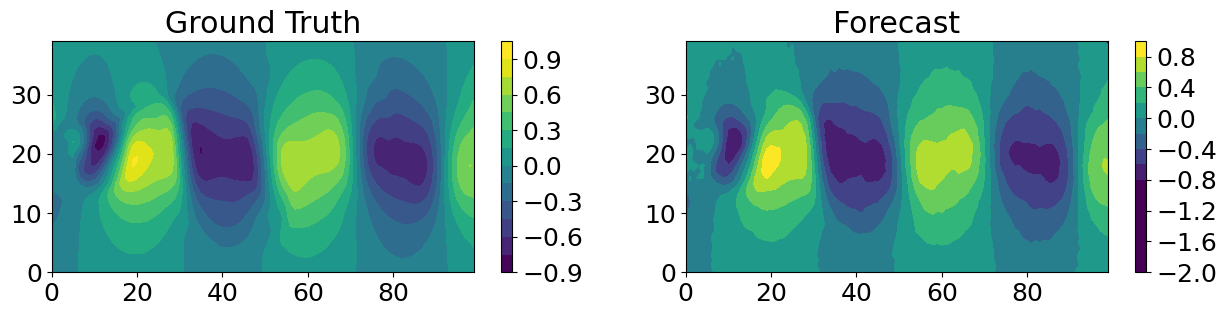

In [44]:
select_snap = 40
span_ch = 32

snap_pred = predictions[:, :, span_ch, select_snap]
snap_target = Ten_orig[1, :, :, span_ch, start_pnt + select_snap]

fig3 = plt.figure(figsize=(15, 3))

vmin = np.amin(snap_target)
vmax = np.amax(snap_target)

plt.subplot(1, 2, 1)
plt.contourf(snap_target.T, 15, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("Ground Truth")

plt.subplot(1, 2, 2)
plt.contourf(snap_pred.T, 15, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("Forecast")